In [8]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

## Wcb Ana

In [2]:
# Load samples (updated 0214)
df0 = {}
df0["ttbarsl"] = uproot.lazy(["/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_YZ_ntuple.root", "/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_FJ_ntuple_id0-499.root", "/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_woFJ_ntuple_id0-999.root"])[1100000:] # exclude training samples
df0["wjets"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/WJetsToLNu_HT150_ntuple_id0-999.root")[1100000:] # exclude training samples
df0["wwsl"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/WWSL_ntuple_id0-99.root")
df0["twsl"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/TWSL_ntuple_id0-99.root")
# df0["wjets_nocut"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/WJetsToLNu_ntuple_id0-99.root")

df0["ttbarsl_wcb"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_WToCB_FJ_ntuple_id0-24.root")
df0["twsl_wcb"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/TWSL_WToCB_ntuple_id0-24.root")
df0["wwsl_wcb"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/WWSL_WToCB_ntuple_id0-24.root")

# total lumi for Run2 + Run3
lumi_tot = 450 # fb-1

# compute weights from un-selected events
weights = {
    "ttbarsl": (lumi_tot / 100.) * 2250000 / len(df0["ttbarsl"]), # number of events passing 1 fj selection
    "wjets": (lumi_tot / 100.) * 6290000 / len(df0["wjets"]), # number of events passing 1 fj selection
    "wwsl": (lumi_tot / 100.) * 1615000 / len(df0["wwsl"]),
    "twsl": (lumi_tot / 100.) * 1108000 / len(df0["twsl"]),
    # "wjets_nocut": (lumi_tot / 100.) * 1802000000 / len(df0["wjets_nocut"]),
    "ttbarsl_wcb": (lumi_tot / 100.) * 2250000 * 0.0008398 / len(df0["ttbarsl_wcb"]), # number of events passing 1 fj selection
    "wwsl_wcb": (lumi_tot / 100.) * 1615000 * 0.0008398 / len(df0["wwsl_wcb"]),
    "twsl_wcb": (lumi_tot / 100.) * 1108000 * 0.0008398 / len(df0["twsl_wcb"]),
}
print({sam: len(df0[sam]) for sam in df0})
print(weights)

# {'ttbarsl': 2570425, 'wjets': 4157131, 'wwsl': 2198372, 'twsl': 1803005, 'wjets_nocut': 2758550}
# {'ttbarsl': 0.8753416263847418, 'wjets': 1.513062734852474, 'wwsl': 0.7346345386495098, 'twsl': 0.6145296324746742, 'wjets_nocut': 653.2417393195701}

{'ttbarsl': 5216209, 'wjets': 4841933, 'wwsl': 2198372, 'twsl': 1803005, 'ttbarsl_wcb': 61364, 'twsl_wcb': 453551, 'wwsl_wcb': 551420}
{'ttbarsl': 1.9410648614731503, 'wjets': 5.8458057969823205, 'wwsl': 3.305855423922794, 'twsl': 2.765383346136034, 'ttbarsl_wcb': 0.1385661788670882, 'wwsl_wcb': 0.01106823564614994, 'twsl_wcb': 0.00923213221886844}


In [4]:
def _get_p4_from_index(_df, obj_str, idx):
    return _p4_from_ptetaphie(
        getattr(_df, obj_str + '_pt')[ak.singletons(idx)][:, 0],
        getattr(_df, obj_str + '_eta')[ak.singletons(idx)][:, 0],
        getattr(_df, obj_str + '_phi')[ak.singletons(idx)][:, 0],
        getattr(_df, obj_str + '_energy')[ak.singletons(idx)][:, 0],
    )
btag_wp = {"L": 0.0557, "M": 0.297, "T": 0.725}
ftag_wp = {"T_b1": 0.8493, "T_b2": 0.5881, "T_c1": 0.7574, "T_c2": 0.2963}

# new variables and selections
df = {}
for sam in df0:
    # fajet selections
    df[sam] = df0[sam][ak.num(df0[sam].fj_pt) > 0]
    d = df[sam]

    # fatjet sophon discr
    df[sam]["fj_sophon_discr"] = d.fj_sophon_probXbc / (d.fj_sophon_probXbc + d.fj_sophon_probQCD)
    df[sam]["fj_sophon_discr2"] = d.fj_sophon_probXbc / (d.fj_sophon_probXbc + d.fj_sophon_probXbq + d.fj_sophon_probXcs + d.fj_sophon_probXbqq + d.fj_sophon_probQCD)
    df[sam]["fj_sophon_discr3"] = d.fj_sophon_probXbc / (d.fj_sophon_probXbc + d.fj_sophon_probXbq + d.fj_sophon_probXcs + d.fj_sophon_probXqq + d.fj_sophon_probXbqq + d.fj_sophon_probQCD)

    # fatjet candidate
    df[sam]["fjcand_p4"] = _get_p4_from_index(d, "fj", np.zeros(len(d), dtype=int))
    df[sam]["fjcand_sdmass"] = d.fj_sdmass[:,0]

    # fatjet candidate-m (with largest Sophon discr)
    df[sam]["fjcandm_idx"] = ak.argmax(d.fj_sophon_discr, axis=1)
    df[sam]["fjcandm_p4"] = _get_p4_from_index(d, "fj", d.fjcandm_idx)
    df[sam]["fjcandm_sdmass"] = d.fj_sdmass[ak.singletons(d.fjcandm_idx)][:, 0]
    df[sam]["fjcandm2_idx"] = ak.argmax(d.fj_sophon_discr2, axis=1)
    df[sam]["fjcandm2_p4"] = _get_p4_from_index(d, "fj", d.fjcandm2_idx)
    df[sam]["fjcandm2_sdmass"] = d.fj_sdmass[ak.singletons(d.fjcandm2_idx)][:, 0]

    # obj p4
    df[sam]["jet_p4"] = _p4_from_ptetaphie(d.jet_pt, d.jet_eta, d.jet_phi, d.jet_energy)
    df[sam]["lep_p4"] = _p4_from_ptetaphie(d.lep_pt, d.lep_eta, d.lep_phi, d.lep_energy)
    zeros = ak.zeros_like(d.lep_pt)
    df[sam]["met_p4"] = _p4_from_ptetaphim(d.met_pt, zeros, d.met_phi, zeros) # note: this is ptetaphim!

    # ### Temporarily commented out ###
    # ## select exclusive LP b jets (for Yuzhe's workflow)
    # df[sam]["extbtagMPjet_p4"] = d.jet_p4[(d.jet_sophonAK4_probB > btag_wp["M"]) & (d.jet_p4.deltaR(d.fjcand_p4) > 0.8)]

    # extbtagMPjet_12_pair = ak.combinations(d.extbtagMPjet_p4[:, :2], 2)
    # df[sam]["dr_extbtagMPjet_12"] = ak.fill_none(ak.firsts(extbtagMPjet_12_pair['0'].deltaR(extbtagMPjet_12_pair['1'])), -1)
    # df[sam]["dr_extbtagMPjet_12_fjcand_min"] = ak.fill_none(ak.firsts(
    #     np.minimum(extbtagMPjet_12_pair['0'].deltaR(d.fjcand_p4), extbtagMPjet_12_pair['1'].deltaR(d.fjcand_p4))
    # ), 99.)

    # # select MP b jets (for ParticleNetSFs workflow)
    # df[sam]["btagMPjet_p4"] = d.jet_p4[d.jet_sophonAK4_probB > btag_wp["M"]]
    # df[sam]["dr_btagMPjet_lep_min"] = ak.fill_none(ak.min(d.btagMPjet_p4.deltaR(d.lep_p4), axis=1), 99.)
    # df[sam]["dr_lep_fjcand"] = d.lep_p4.deltaR(d.fjcand_p4)
    # df[sam]["lepmet_pt"] = (d.lep_p4 + d.met_p4).pt

    # genpart p4 and matchings
    if 'wjets' not in sam:
        df[sam]["whad_idx"] = ak.fill_none(ak.argmax((np.abs(d.genpart_pid[:, :-1]) == 24) & (np.abs(d.genpart_pid[:, 1:]) <= 5), axis=1), 0)

        df[sam]["whad_p4"] = _get_p4_from_index(d, "genpart", d.whad_idx)
        df[sam]["whad_dau1_p4"] = _get_p4_from_index(d, "genpart", d.whad_idx + 1)
        df[sam]["whad_dau2_p4"] = _get_p4_from_index(d, "genpart", d.whad_idx + 2)
        df[sam]["whad_dau1_pid"] = d.genpart_pid[ak.singletons(d.whad_idx + 1)][:, 0]
        df[sam]["whad_dau2_pid"] = d.genpart_pid[ak.singletons(d.whad_idx + 2)][:, 0]

        # if whad follows a b quark, it is from a thad
        df[sam]["thad_b_idx"] = ak.where(
            np.abs(d.genpart_pid[ak.singletons(np.maximum(d.whad_idx - 1, 0))][:, 0]) == 5,
            d.whad_idx - 1,
            -1,
        )
        df[sam]["thad_b_p4"] = _get_p4_from_index(d, "genpart", d.thad_b_idx)

        # check matching criteria
        b_matched = (d.thad_b_idx >= 0) & (d.fjcand_p4.deltaR(d.thad_b_p4) < 0.8)
        wdau1_matched = d.fjcand_p4.deltaR(d.whad_dau1_p4) < 0.8
        wdau2_matched = d.fjcand_p4.deltaR(d.whad_dau2_p4) < 0.8
        df[sam]["is_t_matched"] = b_matched & wdau1_matched & wdau2_matched
        df[sam]["is_w_matched"] = ~b_matched & wdau1_matched & wdau2_matched
        df[sam]["is_tbc_matched"] = (b_matched & (wdau1_matched & (np.abs(d.whad_dau1_pid) == 4)) & ~wdau2_matched) | \
                                     (b_matched & (wdau2_matched & (np.abs(d.whad_dau2_pid) == 4)) & ~wdau1_matched)
        df[sam]["is_tbq_matched"] = (b_matched & (wdau1_matched & (np.abs(d.whad_dau1_pid) != 4)) & ~wdau2_matched) | \
                                     (b_matched & (wdau2_matched & (np.abs(d.whad_dau2_pid) != 4)) & ~wdau1_matched)
        df[sam]["is_non_matched"] = ~d.is_t_matched & ~d.is_w_matched & ~d.is_tbc_matched & ~d.is_tbq_matched

    # infer event DNN scores
    # _df = uproot.lazy(f'/home/olympus/licq/hww/incl-train/weaver-core/weaver/pheno/predict/wcb_boosted_evtobj.noweights.nobj8/pred_{sam}.root')
    # _df = uproot.lazy(f'/home/olympus/licq/hww/incl-train/weaver-core/weaver/pheno/predict/wcb_boosted_evtobj_ftagcat.noweights.nobj8/pred_{sam}.root')
    # _df = uproot.lazy(f'/home/olympus/licq/hww/incl-train/weaver-core/weaver/pheno/predict/wcb_boosted_evtobj_ftagcat_wtmatch.noweights.nobj8/v2/pred_{sam}.root')
    _df = uproot.lazy(f'/home/pku/zhaoyz/pheno/model/v2/pred_{sam}.root')
    for b in ["score_is_w_matched", "score_is_tbQ_matched", "score_is_non_matched", "score_is_wjets"]:
        df[sam][b] = _df[b]
    
    # custom flavour tagging
    df[sam]["jet_ftag_B1"] = d.jet_sophonAK4_probB > ftag_wp["T_b1"]
    df[sam]["jet_ftag_B2"] = (d.jet_sophonAK4_probB > ftag_wp["T_b2"]) & ~d.jet_ftag_B1
    df[sam]["jet_ftag_C1"] = (d.jet_sophonAK4_probC > ftag_wp["T_c1"]) & ~d.jet_ftag_B1 & ~d.jet_ftag_B2
    df[sam]["jet_ftag_C2"] = (d.jet_sophonAK4_probC > ftag_wp["T_c2"]) & ~d.jet_ftag_B1 & ~d.jet_ftag_B2 & ~d.jet_ftag_C1
    df[sam]["jet_ftag_N"] = ~d.jet_ftag_B1 & ~d.jet_ftag_B2 & ~d.jet_ftag_C1 & ~d.jet_ftag_C2

    ##
    
    ## early impl: correct is_wcb
    # if sam == 'ttbarsl':
    #     df[sam]['is_wcb'] = ak.any(np.abs(df[sam].genpart_pid[:, [3,4,8,9]]) == 5, axis=1)
    # elif sam == 'wjets':
    #     df[sam]['is_wcb'] = np.zeros(len(df[sam]), dtype=bool)

print({sam: len(df[sam]) for sam in df})

{'ttbarsl': 4814736, 'wjets': 4552037, 'wwsl': 134177, 'twsl': 243680, 'ttbarsl_wcb': 56597, 'twsl_wcb': 59330, 'wwsl_wcb': 32796}


In [5]:
# Categories
from types import SimpleNamespace
config = SimpleNamespace(
    categories = { # category name: (sample list, selection, label, color)
        "bkg_wjets": (["wjets"], "d.lep_pt > 0", r"Bkg: W+jets", "lightcyan"),
        "bkg_t_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_t_matched", r"Bkg ($t_{bqq'}$)", "blue"),
        "bkg_w_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_w_matched", r"Bkg ($W_{qq'}$)", "red"),
        "bkg_tbc_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbc_matched", r"Bkg ($t_{bc}$)", "orange"),
        "bkg_tbq_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbq_matched", r"Bkg ($t_{bq'}$)", "wheat"),
        "bkg_non_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_non_matched", r"Bkg (non)", "lightyellow"),

        # signals
        "sig_t_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_t_matched", r"Sig ($t_{bqq'}$)", "blue"),
        "sig_w_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_w_matched", r"Sig ($W_{qq'}$)", "red"),
        "sig_tbc_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_tbc_matched", r"Sig ($t_{bc}$)", "orange"),
        "sig_tbq_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_tbq_matched", r"Sig ($t_{bq'}$)", "wheat"),
        "sig_non_matched": (["ttbarsl_wcb", "wwsl_wcb", "twsl_wcb"], "d.is_wcb & d.is_non_matched", r"Sig (non)", "lightyellow"),

        # optional signals
        # "sig_ttbarsl_t_matched": (["ttbarsl_wcb"], "d.is_wcb & d.is_t_matched", r"Sig $t\overline{t}$(SL) ($t_{bqq'}$)", "blue"),
        # "sig_ttbarsl_w_matched": (["ttbarsl_wcb"], "d.is_wcb & d.is_w_matched", r"Sig $t\overline{t}$(SL) ($W_{qq'}$)", "red"),
        # "sig_ttbarsl_tbc_matched": (["ttbarsl_wcb"], "d.is_wcb & d.is_tbc_matched", r"Sig $t\overline{t}$(SL) ($t_{bc}$)", "orange"),
        # "sig_ttbarsl_tbq_matched": (["ttbarsl_wcb"], "d.is_wcb & d.is_tbq_matched", r"Sig $t\overline{t}$(SL) ($t_{bq'}$)", "wheat"),
        # "sig_ttbarsl_non_matched": (["ttbarsl_wcb"], "d.is_wcb & d.is_non_matched", r"Sig $t\overline{t}$(SL) (non)", "lightyellow"),
        # "sig_wwsl_t_matched": (["wwsl_wcb"], "d.is_wcb & d.is_t_matched", r"Sig WW(SL) ($t_{bqq'}$)", "blue"),
        # "sig_wwsl_w_matched": (["wwsl_wcb"], "d.is_wcb & d.is_w_matched", r"Sig WW(SL) ($W_{qq'}$)", "red"),
        # "sig_wwsl_tbc_matched": (["wwsl_wcb"], "d.is_wcb & d.is_tbc_matched", r"Sig WW(SL) ($t_{bc}$)", "orange"),
        # "sig_wwsl_tbq_matched": (["wwsl_wcb"], "d.is_wcb & d.is_tbq_matched", r"Sig WW(SL) ($t_{bq'}$)", "wheat"),
        # "sig_wwsl_non_matched": (["wwsl_wcb"], "d.is_wcb & d.is_non_matched", r"Sig WW(SL) (non)", "lightyellow"),
        # "sig_twsl_t_matched": (["twsl_wcb"], "d.is_wcb & d.is_t_matched", r"Sig tW(SL) ($t_{bqq'}$)", "blue"),
        # "sig_twsl_w_matched": (["twsl_wcb"], "d.is_wcb & d.is_w_matched", r"Sig tW(SL) ($W_{qq'}$)", "red"),
        # "sig_twsl_tbc_matched": (["twsl_wcb"], "d.is_wcb & d.is_tbc_matched", r"Sig tW(SL) ($t_{bc}$)", "orange"),
        # "sig_twsl_tbq_matched": (["twsl_wcb"], "d.is_wcb & d.is_tbq_matched", r"Sig tW(SL) ($t_{bq'}$)", "wheat"),
        # "sig_twsl_non_matched": (["twsl_wcb"], "d.is_wcb & d.is_non_matched", r"Sig tW(SL) (non)", "lightyellow"),

    },

    variables = {
        "n_fj": ("ak.num(d.fj_pt)", bh.axis.Regular(5, 0, 5)),
        "fjcand_pt": ("d.fjcand_p4.pt", bh.axis.Regular(50, 0, 500)),
        "fjcand_eta": ("d.fjcand_p4.eta", bh.axis.Regular(50, -5, 5)),
        "fjcand_mass": ("d.fjcand_p4.mass", bh.axis.Regular(50, 0, 250)),
        "fjcand_sdmass": ("d.fjcand_sdmass", bh.axis.Regular(50, 0, 250)),
        "fjcand_sdmass_bw10": ("d.fjcand_sdmass", bh.axis.Regular(25, 0, 250)),
        "fjcandm_sdmass_bw10": ("d.fjcandm_sdmass", bh.axis.Regular(25, 0, 250)),
        "fjcand_sophon_discr": ("d.fj_sophon_discr[:,0]", bh.axis.Regular(100, 0., 1)),
        "fjcand_sophon_discr2": ("d.fj_sophon_discr2[:,0]", bh.axis.Regular(100, 0., 1)),
        "fjcand_sophon_discr_custom": ("d.fj_sophon_probXbc[:,0] / (d.fj_sophon_probXbc[:,0] + d.fj_sophon_probXbq[:,0] + d.fj_sophon_probXcs[:,0] + d.fj_sophon_probXqq[:,0] + d.fj_sophon_probXbqq[:,0])", bh.axis.Regular(100, 0.5, 1)),
        "lep_pt": ("d.lep_pt", bh.axis.Regular(50, 0, 500)),
        "lep_eta": ("d.lep_eta", bh.axis.Regular(50, -5, 5)),
        "met_pt": ("d.met_pt", bh.axis.Regular(50, 0, 500)),
        "wlep_pt": ("(d.met_p4 + d.lep_p4).pt", bh.axis.Regular(50, 0, 500)),
        "n_extbtagMPjet": ("ak.num(d.extbtagMPjet_p4)", bh.axis.Regular(6, 0, 6)),
        # "n_extbtagMPjet": ("ak.num(d.jet_p4[(d.jet_sophonAK4_probB > 0.297) & (d.jet_p4.deltaR(d.fjcand_p4) > 0.8)])", bh.axis.Regular(6, 0, 6)),
        "n_extjet": ("ak.num(d.jet_p4[(d.jet_p4.deltaR(d.fjcand_p4) > 0.8)])", bh.axis.Regular(10, 0, 10)),
        "n_cleanjet": ("ak.num(d.jet_p4[(d.jet_p4.deltaR(d.fjcand_p4) > 0.8) & (d.jet_p4.deltaR(d.lep_p4) > 0.4)])", bh.axis.Regular(10, 0, 10)),
        "evt_dnn_score": ("d.score_is_w_matched", bh.axis.Regular(50, 0, 1)),
        "evt_dnn_score_high": ("d.score_is_w_matched", bh.axis.Regular(50, 0.8, 1)),
        "evt_dnn_score_tonly": ("d.score_is_w_matched / (1 - d.score_is_wjets)", bh.axis.Regular(50, 0, 1)),
        "dr_extbtagMPjet_12_fjcand_min": ("d.dr_extbtagMPjet_12_fjcand_min", bh.axis.Regular(30, 0, 6)),

        # for template making
        "sophon_discr2_dnn_hist2d": (("d.fj_sophon_discr2[:,0]", "d.score_is_w_matched"), (bh.axis.Regular(100, 0.9, 1), bh.axis.Regular(100, 0, 1))),
        "sophon_discr3_dnn_hist2d": (("d.fj_sophon_discr3[:,0]", "d.score_is_w_matched"), (bh.axis.Regular(100, 0.9, 1), bh.axis.Regular(100, 0, 1))),
    },

    signal_mul_factor = 10,

    categories_merged = {
        "bkg_wjets": ["bkg_wjets"],
        "bkg_allwhad_tbc": ["bkg_tbc_matched"],
        "bkg_allwhad_others": ["bkg_t_matched", "bkg_w_matched", "bkg_tbq_matched", "bkg_non_matched"],
        "sig": ["sig_t_matched", "sig_w_matched", "sig_tbc_matched", "sig_tbq_matched", "sig_non_matched"],
    }
)
# btag_wp = {"L": 0.0557, "M": 0.297, "T": 0.725}


In [6]:
# cached df
dfc = {}
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        d = df[sam]
        dfc[(cname, sam)] = df[sam][eval(sel)]

## Plotting

Selection: (d.lep_pt > 0) & (d.fj_sophon_discr3[:,0] > 0.95) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)
Variable: d.score_is_w_matched
Processing bkg_wjets wjets
Processing bkg_t_matched ttbarsl
Processing bkg_t_matched wwsl
Processing bkg_t_matched twsl
Processing bkg_w_matched ttbarsl
Processing bkg_w_matched wwsl
Processing bkg_w_matched twsl
Processing bkg_tbc_matched ttbarsl
Processing bkg_tbc_matched wwsl
Processing bkg_tbc_matched twsl
Processing bkg_tbq_matched ttbarsl
Processing bkg_tbq_matched wwsl
Processing bkg_tbq_matched twsl
Processing bkg_non_matched ttbarsl
Processing bkg_non_matched wwsl
Processing bkg_non_matched twsl
Processing sig_t_matched ttbarsl_wcb
Processing sig_t_matched wwsl_wcb
Processing sig_t_matched twsl_wcb
Processing sig_w_matched ttbarsl_wcb
Processing sig_w_matched wwsl_wcb
Processing sig_w_matched twsl_wcb
Processing sig_tbc_matched ttbarsl_wcb
Processing sig_tbc_matched wwsl_wcb
Processing sig_tbc_matched twsl_wcb
Processing sig_tbq_matched

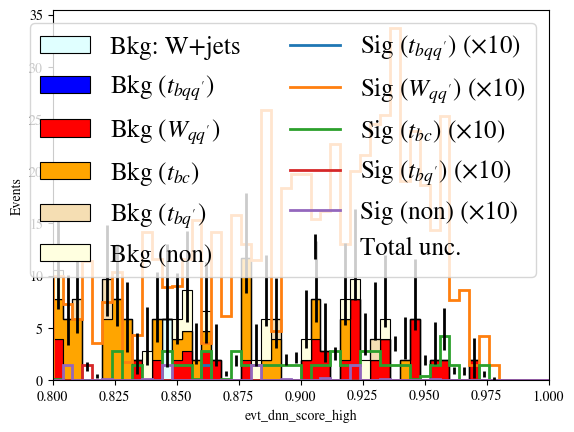

In [9]:
basesel_expr = "(d.lep_pt > 0)"
# basesel_expr = "(ak.num(d.extbtagMPjet_p4) == 2) & (d.dr_extbtagMPjet_12 > 1.) & (d.dr_extbtagMPjet_12_fjcand_min < 2.)"

# try ParticleNetSFs cut:
# basesel_expr = "(d.lep_pt > 50.) & (d.met_pt > 50.) & (d.dr_btagMPjet_lep_min < 2.) & (d.dr_lep_fjcand > 2.) & (d.lepmet_pt > 100.)"

# tagger cut
# basesel_expr += " & (d.fj_sophon_discr[:,0] > 0.95)"
basesel_expr += " & (d.fj_sophon_discr3[:,0] > 0.95)"
# basesel_expr += " & (d.fj_sophon_probXbc[:,0] / (d.fj_sophon_probXbc[:,0] + d.fj_sophon_probXbq[:,0] + d.fj_sophon_probXcs[:,0] + d.fj_sophon_probXqq[:,0] + d.fj_sophon_probXbqq[:,0] + 10*d.fj_sophon_probQCD[:,0]) > 0.93)"
# basesel_expr += " & (d.fj_sophon_discr2[:,0] > 0.5)"

# DNN cut
# basesel_expr += " & (d.score_is_w_matched > 0.85)"

# mass window cut
basesel_expr += " & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)"


# varname = "wlep_pt"; do_plotting = True
varname = "evt_dnn_score_high"; do_plotting = True
# varname = "fjcand_sophon_discr2"; do_plotting = True

categories_to_draw = [
    "bkg_wjets",
    "bkg_t_matched", "bkg_w_matched", "bkg_tbc_matched", "bkg_tbq_matched", "bkg_non_matched",
    "sig_t_matched", "sig_w_matched", "sig_tbc_matched", "sig_tbq_matched", "sig_non_matched",
    # "sig_ttbarsl_t_matched", "sig_ttbarsl_w_matched", "sig_ttbarsl_tbc_matched", "sig_ttbarsl_tbq_matched", "sig_ttbarsl_non_matched",
    # "sig_wwsl_t_matched", "sig_wwsl_w_matched", "sig_wwsl_tbc_matched", "sig_wwsl_tbq_matched", "sig_wwsl_non_matched",
    # "sig_twsl_t_matched", "sig_twsl_w_matched", "sig_twsl_tbc_matched", "sig_twsl_tbq_matched", "sig_twsl_non_matched",
    ]

varexpr, varaxis = config.variables[varname]
print("Selection:", basesel_expr)
print("Variable:", varexpr)

def _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=1):
    def _fill_hist(input):
        vals, weights = input
        hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
        hist.fill(vals, weight=weights)
        return hist

    if nthreads == 1:
        return _fill_hist((var_array, weight_array))
    else:
        with ThreadPoolExecutor(nthreads) as pool:
            hist = pool.map(_fill_hist, zip(np.array_split(var_array, nthreads), np.array_split(weight_array, nthreads)))
        hist = reduce(add, hist)
        return hist

def _plotter(input):
    cname, sam = input
    print('Processing', cname, sam)
    # base selection
    d = dfc[(cname, sam)]
    d = d[eval(basesel_expr)]
    # fill histogram
    var_array = eval(varexpr)
    weight_array = np.ones(len(d))
    hist = _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=4)
    # yields ... tbd
    # yld = len(d[(d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)])
    yld = len(d)
    return hist, yld

# generate inputs to send into concurrent plotter
zipped_input = []
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        zipped_input.append((cname, sam))

# plotting
if do_plotting:
    with ThreadPoolExecutor(2) as pool:
        results = dict(zip(zipped_input, pool.map(_plotter, zipped_input)))

# retreive and group results for each category
contents, variances, contents_mass_win = {}, {}, {}
for cname, (samlist, sel, label, color) in config.categories.items():
    hists = []
    contents_mass_win[cname] = 0
    for sam in samlist:
        hists.append(results[(cname, sam)][0] * weights[sam])
        contents_mass_win[cname] += results[(cname, sam)][1] * weights[sam]
    hist = sum(hists)
    contents[cname], variances[cname] = hist.view().value, hist.view().variance
    print(cname, round(contents_mass_win[cname], 1))
print(
    '**Significance**',
    sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("sig")]) / np.sqrt(sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("bkg")])),
)

# plotting: stacked histogram
fig, ax = plt.subplots()
hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
hep.histplot(
    [contents[cname] for cname in categories_to_draw if cname.startswith("bkg")],
    bins=hist.axes[0].edges,
    label=[config.categories[cname][2] for cname in categories_to_draw if cname.startswith("bkg")],
    color=[config.categories[cname][3] for cname in categories_to_draw if cname.startswith("bkg")],
    histtype='fill', edgecolor='k', linewidth=0.8, stack=True,
)
# plotting: signals
hep.histplot(
    [contents[cname] * config.signal_mul_factor for cname in categories_to_draw if cname.startswith("sig")],
    bins=hist.axes[0].edges,
    label=[config.categories[cname][2] + f' (×{config.signal_mul_factor})' for cname in categories_to_draw if cname.startswith("sig")],
    linewidth=2,
)
# SM errorbar
ax.errorbar(
    (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:])/2.,
    sum([contents[cname] for cname in categories_to_draw]),
    yerr=np.sqrt(sum([variances[cname] for cname in categories_to_draw])),
    label='Total unc.', color='black', linewidth=2, linestyle='none',
)

ax.set_xlim(varaxis.edges[0], varaxis.edges[-1])
ax.set_xlabel(varname)
ax.set_ylabel("Events")
# ax.set_yscale("log")
ax.legend(prop={'size': 18}, loc='upper right', ncol=2)
plt.show()

/tmp/ipykernel_1287775/4009700300.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(2*((s + b)*(np.log(1 + s/b)) - s))


2.360750607216898 inf


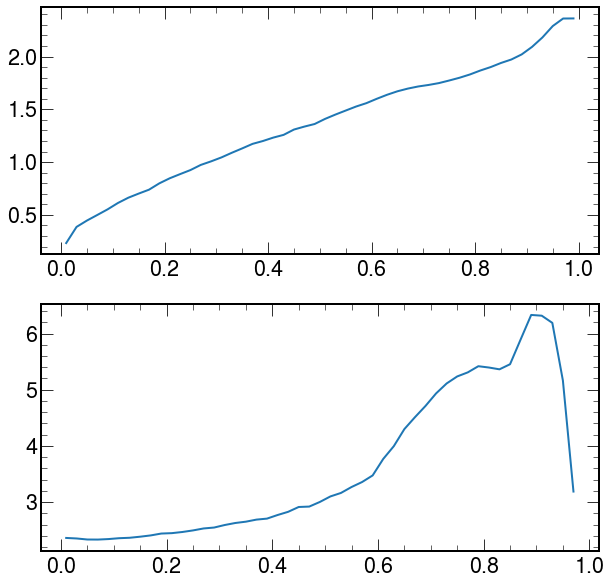

In [37]:
# significance curve
def signif(s, b):
    return np.sqrt(2*((s + b)*(np.log(1 + s/b)) - s))

hist_bkg = sum([contents[cname] for cname in categories_to_draw if cname.startswith("bkg")])
hist_sig = sum([contents[cname] for cname in categories_to_draw if cname.startswith("sig")])
x = hist.axes[0].centers
z_inv = signif(np.cumsum(hist_sig), np.cumsum(hist_bkg))
z = signif(np.cumsum(hist_sig[::-1])[::-1], np.cumsum(hist_bkg[::-1])[::-1])
# z_inv = np.nan_to_num(z_inv, nan=0)
# z = np.nan_to_num(z, nan=0)

fig, axs = plt.subplots(2, 1)
axs[0].plot(x, z_inv, label='Sig. (inv.)', linewidth=2)
axs[1].plot(x, z, label='Sig.', linewidth=2)
print(np.max(z_inv), np.max(z))

## Flavour-tagging uncertainties & Fit templates

In [10]:
# Assign the SF value from the SF tables depending on truth label, ftag region, and pT
ftag_sf = {
    "bjet": {
        "pt_edges": [20, 30, 40, 60, 100, 175, 250],
        "B1": [0.07, 0.04, 0.03, 0.01, 0.01, 0.02, 0.03],
        "B2": [0.07, 0.04, 0.03, 0.02, 0.03, 0.04, 0.08],
        "C1": [0.06, 0.03, 0.02, 0.02, 0.03, 0.06, 0.14],
        "C2": [0.05, 0.03, 0.01, 0.01, 0.02, 0.04, 0.10],
        "N":  [0.20, 0.12, 0.08, 0.05, 0.07, 0.08, 0.13],
    },
    "cjet": {
        "pt_edges": [20, 40, 65, 140],
        "B1": [0.10, 0.08, 0.08, 0.08],
        "B2": [0.10, 0.05, 0.05, 0.06],
        "C1": [0.10, 0.04, 0.04, 0.04],
        "C2": [0.07, 0.07, 0.06, 0.06],
        "N":  [0.07, 0.04, 0.04, 0.04],
    },
    "ljet": {
        "pt_edges": [20, 50, 100, 150],
        "B1": [0.23, 0.22, 0.24, 0.20],
        "B2": [0.22, 0.22, 0.25, 0.20],
        "C1": [0.12, 0.12, 0.13, 0.12], 
        "C2": [0.13, 0.13, 0.13, 0.12],
        "N":  [0.0035, 0.0025, 0.0025, 0.0022],
    },
}
for sam in df:
    d = df[sam]

    # flatten the pT array
    jet_pt_flat = ak.flatten(d.jet_pt)
    counts = ak.num(d.jet_pt)

    # initiate SFs
    sf = np.zeros(len(jet_pt_flat))

    for flv in ["bjet", "cjet", "ljet"]:
        if flv == "bjet":
            truth_flag = (d.jet_flavor == 5)
        elif flv == "cjet":
            truth_flag = (d.jet_flavor == 4)
        else:
            truth_flag = (d.jet_flavor != 5) & (d.jet_flavor != 4)

        # for each truth flavour, assign the corresponding SF from the 5 regions and the corresponding SF table
        for ch in ["B1", "B2", "C1", "C2", "N"]:
            _idx = np.searchsorted(ftag_sf[flv]["pt_edges"], np.maximum(ak.to_numpy(jet_pt_flat), 20+1e-8)) - 1
            _sf = np.array(ftag_sf[flv][ch])[_idx]
            flag_flat = ak.flatten(truth_flag * getattr(d, f"jet_ftag_{ch}"))
            sf = sf + _sf * flag_flat

    df[sam]['jet_ftag_SF'] = ak.unflatten(sf, counts)

In [15]:
# cached df
dfc = {}
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        d = df[sam]
        dfc[(cname, sam)] = df[sam][eval(sel)]

In [16]:
dfc[("bkg_wjets","wjets")].jet_ftag_SF

<Array [[0.12, 0.13], ... 0.07, 0.0022]] type='4552037 * var * float64'>

In [12]:
df["ttbarsl"]['jet_ftag_SF'][0] 

<Array [0.01, 0.0025, ... 0.0035, 0.0035] type='6 * float64'>

In [17]:
# make event DNN template

def make_flv_variation_template(target_flv, target_region, target_variation):

    assert target_flv in ["bjet", "cjet", "ljet"]
    assert target_region in ["B1", "B2", "C1", "C2", "N"]
    assert target_variation in ["up", "down", "nominal"]
    print(f"Making template for {target_flv} in {target_region} with {target_variation} variation")

    basesel_expr = "(d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)"

    # DNN cut
    # basesel_expr += " & (d.score_is_w_matched > 0.85)"

    varname = "sophon_discr2_dnn_hist2d"; do_plotting = True

    categories_to_draw = [
        "bkg_wjets",
        "bkg_t_matched", "bkg_w_matched", "bkg_tbc_matched", "bkg_tbq_matched", "bkg_non_matched",
        "sig_t_matched", "sig_w_matched", "sig_tbc_matched", "sig_tbq_matched", "sig_non_matched",
        ]

    varexpr, varaxis = config.variables[varname]
    assert isinstance(varexpr, tuple), "Only 2D hist is supported"

    print("Selection:", basesel_expr)
    print("Variable:", varexpr)

    # fill the histogram
    # notice! 2D fit
    def _concurrent_hist_filler(varaxis, var_array1, var_array2, weight_array, nthreads=1):
        def _fill_hist(input):
            vals1, vals2, weights = input
            hist = bh.Histogram(varaxis[0], varaxis[1], storage=bh.storage.Weight())
            hist.fill(vals1, vals2, weight=weights)
            return hist

        if nthreads == 1:
            return _fill_hist((var_array1, var_array2, weight_array))
        else:
            with ThreadPoolExecutor(nthreads) as pool:
                hist = pool.map(_fill_hist, zip(np.array_split(var_array1, nthreads), np.array_split(var_array2, nthreads), np.array_split(weight_array, nthreads)))
            hist = reduce(add, hist)
            return hist

    # process each category from each sample
    def _plotter(input):
        cname, sam = input
        # print('Processing', cname, sam)
        # base selection
        d = dfc[(cname, sam)]
        d = d[eval(basesel_expr)]
        # fill histogram
        var_array1 = eval(varexpr[0])
        var_array2 = eval(varexpr[1])

        ##### custom weight array #####
        target_flv_map = {
            "bjet": "d.jet_flavor == 5",
            "cjet": "d.jet_flavor == 4",
            "ljet": "(d.jet_flavor != 5) & (d.jet_flavor != 4)",
        }
        target_region_map = {
            'B1': "d.jet_ftag_B1",
            'B2': "d.jet_ftag_B2",
            'C1': "d.jet_ftag_C1",
            'C2': "d.jet_ftag_C2",
            'N': "d.jet_ftag_N",
        }

        cleanjet_flag = (d.jet_p4.deltaR(d.lep_p4) > 0.4) & (d.jet_p4.deltaR(d.fjcand_p4) > 0.8) & (d.jet_pt > 25) # reminder of pt > 25 cut!
        flv_flag = eval(target_flv_map[target_flv]) #truth flavor tagging label/flag
        region_flag = eval(target_region_map[target_region]) #tagged region

        if target_variation == 'up':
            weight_array = ak.prod((1 + d.jet_ftag_SF)[cleanjet_flag & flv_flag & region_flag], axis=1)
        elif target_variation == 'down':
            weight_array = ak.prod((1 - d.jet_ftag_SF)[cleanjet_flag & flv_flag & region_flag], axis=1)
        else:
            weight_array = np.ones(len(d))
        ##### end custom weight array #####

        hist = _concurrent_hist_filler(varaxis, var_array1, var_array2, weight_array, nthreads=4)
        # yields within ... tbd
        yld = len(d[d.score_is_w_matched > 0.96])
        return hist, yld

    # generate inputs to send into concurrent plotter
    # zipped_input only contain the (cname: category name, sam: sample)
    zipped_input = []
    for cname, (samlist, sel, label, color) in config.categories.items():
        for sam in samlist:
            zipped_input.append((cname, sam))

    # plotting
    # the process order is: call _plotter for all (cname, sam) in zipped_input
    # for each (cname, sam), again call _concurrent_hist_filler to do the fill
    # all the results are 
    if do_plotting:
        with ThreadPoolExecutor(2) as pool:
            results = dict(zip(zipped_input, pool.map(_plotter, zipped_input)))

    # retreive and group results for each category
    contents, variances, contents_mass_win = {}, {}, {}
    hists = {}
    for cname, (samlist, sel, label, color) in config.categories.items():
        _hists = []
        contents_mass_win[cname] = 0
        for sam in samlist:
            _hists.append(results[(cname, sam)][0] * weights[sam]) 
            contents_mass_win[cname] += results[(cname, sam)][1] * weights[sam]
        hists[cname] = sum(_hists) # sum over all the category from all samples
        contents[cname], variances[cname] = hists[cname].view().value, hists[cname].view().variance
        # print(cname, round(contents_mass_win[cname], 1))

    templs = {} 
    # again, we need the templates only for the key in categories_merged:
    # like bkg_wjets, bkg_allwhad_tbc, bkg_allwhad_others, sig
    
    for cm in config.categories_merged:
        templs[cm] = sum([hists[cname] for cname in config.categories_merged[cm]])

    return templs

templs_summary = {}
for target_flv in ["bjet", "cjet", "ljet"]:
    for target_region in ["B1", "B2", "C1", "C2", "N"]:
        for target_variation in ["up", "down"]:
            templs_summary[f"{target_flv}_{target_region}_{target_variation}"] = make_flv_variation_template(target_flv, target_region, target_variation)
templs_summary["nom"] = make_flv_variation_template("bjet", "B1", "nominal")

Making template for bjet in B1 with up variation
Selection: (d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)
Variable: ('d.fj_sophon_discr2[:,0]', 'd.score_is_w_matched')
Making template for bjet in B1 with down variation
Selection: (d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)
Variable: ('d.fj_sophon_discr2[:,0]', 'd.score_is_w_matched')
Making template for bjet in B2 with up variation
Selection: (d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)
Variable: ('d.fj_sophon_discr2[:,0]', 'd.score_is_w_matched')
Making template for bjet in B2 with down variation
Selection: (d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)
Variable: ('d.fj_sophon_discr2[:,0]', 'd.score_is_w_matched')
Making template for bjet in C1 with up variation
Selection: (d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)
Variable: ('d.fj_sophon_discr2[:,0]', 'd.score_is_w_matched')
Making template for bjet in C1 with down variation
Selec

In [13]:
import pickle

# # 2025.02.13: split bkg into bkg_wjets and bkg_allwhad
# with open("pickles/wcb_ana_templ_2dhist_spdiscr3_newsample_v0213.pkl", "wb") as f:
#     pickle.dump(templs_summary, f)

# 2025.02.16: switch to obj jet pt > 25
# with open("pickles/wcb_ana_templ_2dhist_spdiscr2_newsample_v0216.pkl", "wb") as f:
#     pickle.dump(templs_summary, f)
    
with open("pickles/yuzhe_wcb_ana.pkl", "wb") as f:
    pickle.dump(templs_summary, f)

# import pickle
# with open("pickles/wcb_ana_templ.pkl", "rb") as f:
#     sig_templs, bkg_templs = pickle.load(f)
# with open("pickles/wcb_ana_templ_2dhist_spdiscr2_newsample_v0213.pkl", "rb") as f:
#     templs_summary = pickle.load(f)

# # verify the results: nominal histogram for sophon_discr2 > 0.95
# print(templs_summary["nom"]["sig"][5::bh.sum, :].values())
# print(sig_templs["nom"].values())

NameError: name 'templs_summary' is not defined

In [36]:
# ## write templates
# filedir = './datacards/boosted'
# aux_weight_scale = 3000. / 450 # for HL-LHC
# # aux_weight_scale = 1.

# sophon_discr_thres = 0.952  # 0.9xx
# evt_dnn_thres = 0.89  # 0.9x

# import copy
# _templs = copy.deepcopy(templs_summary) ## important!

# hist_out = {}
# # should first sum over the first Sophon discr index (start:end:bh.sum)
# for cm in config.categories_merged:
#     hist_out[cm] = _templs["nom"][cm][int(sophon_discr_thres*1000)-900::bh.sum, :] ## important!

# for target_flv in ["bjet", "cjet", "ljet"]:
#     for target_region in ["B1", "B2", "C1", "C2", "N"]:
#         for target_variation in ["up", "down"]:
#             _variation = "Up" if target_variation == "up" else "Down"
#             for cm in config.categories_merged:
#                 n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"
#                 hist_out[n] = _templs[f"{target_flv}_{target_region}_{target_variation}"][cm][int(sophon_discr_thres*1000)-900::bh.sum, :] ## important!
#                 # make sure the total yields doesn't change
#                 hist_out[n].view().value *= sum(hist_out[cm].view().value) / sum(hist_out[n].view().value)
#                 hist_out[n].view().variance *= (sum(hist_out[cm].view().value) / sum(hist_out[n].view().value))**2

# hist_out['data_obs'] = sum(hist_out[cm] for cm in config.categories_merged)

# # aux weight scale
# for n in hist_out:
#     hist_out[n].view().value *= aux_weight_scale
#     hist_out[n].view().variance *= aux_weight_scale**2


# # rebin the DNN score
# # === old setup ===
# # for n in hist_out:
# #     # hist_out[n] = hist_out[n][bh.loc(0.96):bh.loc(1.0):bh.rebin(4)] # 1 bin from 0.96--1
# #     hist_out[n] = hist_out[n][bh.loc(0.6):bh.loc(1.0):bh.rebin(4)]
# #     hist_out[n].view().variance *= 0
# # ======
# def rebin_hist_var_width(orig_hist, new_axis):
#     new_hist = bh.Histogram(new_axis, storage=bh.storage.Weight())
#     for i in range(orig_hist.axes[0].size):
#         bin_center = orig_hist.axes[0].centers[i]
#         if bin_center > new_axis.edges[0] and bin_center < new_axis.edges[-1]:
#             new_idx = np.searchsorted(new_axis.edges, bin_center) - 1
#             new_hist.view().value[new_idx] += orig_hist.view().value[i]
#             new_hist.view().variance[new_idx] += orig_hist.view().variance[i]
#     return new_hist

# for n in hist_out:
#     hist_out[n] = rebin_hist_var_width(hist_out[n], bh.axis.Variable([0, evt_dnn_thres, 1.0]))
#     hist_out[n].view().value = np.maximum(hist_out[n].view().value, 1e-3)
#     hist_out[n].view().variance *= 0

# print('Apply aux weight scale:', aux_weight_scale)
# print(hist_out['data_obs'].values().sum())

# with uproot.recreate(f'{filedir}/input_SR.root') as fw:
#     for n in hist_out:
#         fw[n] = hist_out[n]

# lines = open(f'{filedir}/datacard.txt').readlines()
# for i, line in enumerate(lines):
#     if line.startswith('observation'):
#         lines[i] = f'observation {hist_out["data_obs"].values().sum()}\n'
# with open(f'{filedir}/datacard.txt', 'w') as f:
#     f.writelines(lines)

Apply aux weight scale: 6.666666666666667
935.9043866227433


### Write templates for two bins

In [8]:
templs_summary['nom']['bkg_wjets'].view(flow=True).value.sum()

3589505.979326851

In [53]:
## write templates
filedir = './datacards/boosted'
aux_weight_scale = 3000. / 450 # for HL-LHC
# aux_weight_scale = 1.
aux_flavor_strength = 1

# 0.xxx, 0.xx
sophon_discr_thres = 0.95; evt_dnn_thres = 0.87  # 0.951, 0.87 optimal for strength=1; 0.95, 0.86 optimal for strength=0.5

import copy
_templs = copy.deepcopy(templs_summary) ## important!

hist_out = {}
# should first sum over the first Sophon discr index (start:end:bh.sum)
for cm in config.categories_merged:
    hist_out[cm] = _templs["nom"][cm][int(sophon_discr_thres*1000)-900::bh.sum, :] ## important!

for target_flv in ["bjet", "cjet", "ljet"]:
    for target_region in ["B1", "B2", "C1", "C2", "N"]:
        for target_variation in ["up", "down"]:
            _variation = "Up" if target_variation == "up" else "Down"
            # get the inclusive non-flavour-cut template's total yield
            nevt_tot_nom = sum(_templs["nom"][cm].view(flow=True).value.sum() for cm in config.categories_merged)
            nevt_tot_flv = sum(_templs[f"{target_flv}_{target_region}_{target_variation}"][cm].view(flow=True).value.sum() for cm in config.categories_merged)
            fac =  nevt_tot_nom / nevt_tot_flv

            for cm in config.categories_merged:
                n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"
                hist_out[n] = _templs[f"{target_flv}_{target_region}_{target_variation}"][cm][int(sophon_discr_thres*1000)-900::bh.sum, :] ## important!
                # make sure the total yields doesn't change
                hist_out[n].view().value *= fac
                hist_out[n].view().variance *= fac**2
                # hist_out[n].view().value *= sum(hist_out[cm].view().value) / sum(hist_out[n].view().value)
                # hist_out[n].view().variance *= (sum(hist_out[cm].view().value) / sum(hist_out[n].view().value))**2

hist_out['data_obs'] = sum(hist_out[cm] for cm in config.categories_merged)

# aux weight scale
for n in hist_out:
    hist_out[n].view().value *= aux_weight_scale
    hist_out[n].view().variance *= aux_weight_scale**2


# rebin the DNN score
# === old setup ===
# for n in hist_out:
#     # hist_out[n] = hist_out[n][bh.loc(0.96):bh.loc(1.0):bh.rebin(4)] # 1 bin from 0.96--1
#     hist_out[n] = hist_out[n][bh.loc(0.6):bh.loc(1.0):bh.rebin(4)]
#     hist_out[n].view().variance *= 0
# ======
def rebin_hist_var_width(orig_hist, new_axis):
    new_hist = bh.Histogram(new_axis, storage=bh.storage.Weight())
    for i in range(orig_hist.axes[0].size):
        bin_center = orig_hist.axes[0].centers[i]
        if bin_center > new_axis.edges[0] and bin_center < new_axis.edges[-1]:
            new_idx = np.searchsorted(new_axis.edges, bin_center) - 1
            new_hist.view().value[new_idx] += orig_hist.view().value[i]
            new_hist.view().variance[new_idx] += orig_hist.view().variance[i]
    return new_hist

# write two templates: SR1 and SR2
hist_out1, hist_out2 = {}, {}
for n in hist_out:
    hist_out1[n] = rebin_hist_var_width(hist_out[n], bh.axis.Variable([evt_dnn_thres, 1.0])) # pass DNN bin
    hist_out1[n].view().value = np.maximum(hist_out1[n].view().value, 1e-3)
    hist_out1[n].view().variance *= 0

    hist_out2[n] = rebin_hist_var_width(hist_out[n], bh.axis.Variable([0, evt_dnn_thres])) # fail DNN bin
    hist_out2[n].view().value = np.maximum(hist_out2[n].view().value, 1e-3)
    hist_out2[n].view().variance *= 0

import re
for n in hist_out:
    if 'ftag' in n:
        hist_out1[n].view().value = hist_out1[n].view().value * aux_flavor_strength + hist_out1[re.sub(r"(_ftag_.*)", "", n)].view().value * (1 - aux_flavor_strength)
        hist_out2[n].view().value = hist_out2[n].view().value * aux_flavor_strength + hist_out2[re.sub(r"(_ftag_.*)", "", n)].view().value * (1 - aux_flavor_strength)

print('Apply aux weight scale:', aux_weight_scale)
print(hist_out1['data_obs'].values().sum(), hist_out2['data_obs'].values().sum())

with uproot.recreate(f'{filedir}/input_SR1.root') as fw:
    for n in hist_out1:
        fw[n] = hist_out1[n]
with uproot.recreate(f'{filedir}/input_SR2.root') as fw:
    for n in hist_out2:
        fw[n] = hist_out2[n]

lines = open(f'{filedir}/datacard.txt').readlines()
for i, line in enumerate(lines):
    if line.startswith('observation'):
        lines[i] = f'observation {hist_out1["data_obs"].values().sum()} {hist_out2["data_obs"].values().sum()}\n'
with open(f'{filedir}/datacard.txt', 'w') as f:
    f.writelines(lines)

Apply aux weight scale: 6.666666666666667
876.1882682047756 182198.26210505684


In [55]:
val_nom = sum([hist_out1[n].values().sum() for n in hist_out1 if n.startswith('bkg') and 'ftag' not in n])
print(val_nom)
array = []
for target_flv in ["bjet", "cjet", "ljet"]:
    _array = []
    for target_region in ["B1", "B2", "C1", "C2", "N"]:
        val_up = sum([hist_out1[n].values().sum() for n in hist_out1 if n.startswith('bkg') and n.endswith(f'{target_flv}_{target_region}Up')])
        _array.append((val_up/val_nom - 1)*100)
    array.append(_array)
print(array)

548.9946177769014
[[2.1007249429044528, 0.2979909670017822, -0.044755524615536224, -0.12383434687920358, -0.9005007307689605], [0.1714189807042965, 0.08304541175025992, -0.2079335417459971, 0.033616828883764605, -0.04997412058296291], [-0.02396669155214637, 0.46507002239113415, -0.02619330942401632, -0.44456322779067303, -0.13952515084986183]]


/tmp/ipykernel_2711615/2163951335.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


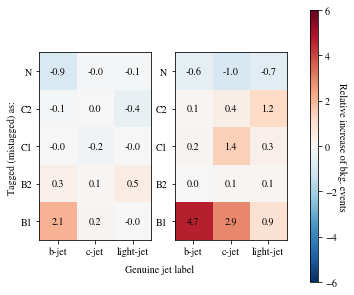

In [56]:
# Create a 3x3 matrix of z-values
# data = np.array([[1.2, 2.3, 3.4],
#                  [4.5, 5.6, 6.7],
#                  [7.8, 8.9, 9.0]])
data_array = [
    np.array(array).T,
    np.array([[4.654024413603675, 0.010297171374684666, 0.15590100259761375, 0.10026003282270768, -0.5662913273807635], [2.88229649681786, 0.11138602309281875, 1.4128676573476717, 0.39523433236194894, -0.973026086812967], [0.9086149598416471, 0.13839490623126505, 0.29344122618402135, 1.1874620225657662, -0.6816885404062001]]).T, # 0.970
    # np.array([[4.5015357846655, -0.027473155976209807, 0.14720344655207995, 0.057804330396837855, -0.6590326434728788], [3.134338865015507, 0.04261036366726145, 1.8130505732519175, 0.14167679411003498, -1.036932410177227], [1.3074999807465737, -0.03325869048752539, 0.27322272033956096, 1.0121406833812907, -0.7046757632660716]]).T, # 0.980
    # np.array([[4.3154339599616565, -0.005879668376895797, 0.19968639286453982, 0.12559227663244688, -0.4927207706913017], [2.8992095426248365, 0.09828538721046165, 2.2622328781211065, -0.08258132263225804, -0.9644319235892485], [1.7963981015266084, 0.0636752310981814, 0.3256976078513274, 0.03286323184086282, -0.7065341867258268]]).T, # 0.985
    # np.array([[3.3830733848060124, -0.22434166835786362, 0.43279891381651225, 0.177739081186834, -0.912749411990077], [2.874774955462711, 0.07952723395081573, 2.1156703839583457, 0.26337634160320533, -0.8043517017062074], [2.3716642549796774, -0.10817333297310494, -0.05725112976669999, -1.3966039369522787, -0.7128848678188193]]).T, # 0.990
]

# Define the axis labels
x_labels = ['b-jet', 'c-jet', 'light-jet']
y_labels = ['B1', 'B2', 'C1', 'C2', 'N']

fig = plt.figure(figsize=(5, 5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.07], wspace=0.3)

# Create subplots for the two plots
axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]
cax = plt.subplot(gs[2])

# Plot the data using imshow
ims = {}
for i in [0, 1]:
    ax = axes[i]
    data = data_array[i]
    ims[i] = ax.imshow(data, cmap='RdBu_r', vmin=-6, vmax=6)

    # Set x and y ticks and labels
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels)
    ax.set_xlim(-0.5, len(x_labels)-0.5)
    ax.set_ylim(-0.5, len(y_labels)-0.5)

    # Annotate each cell with the corresponding z-value
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = f"{data[i, j]:.1f}"  # Format the number to one decimal
            # text_color = 'white' if im.norm(data[i, j]) > 0.5 else 'black'
            text_color = 'black'
            ax.text(j, i, text, ha='center', va='center', color=text_color)

# Add a colorbar to show the mapping of z-values to colors
cbar = fig.colorbar(ims[1], cax=cax, shrink=0.8)
cbar.set_label('Relative increase of bkg. events', rotation=270, labelpad=10)

fig.text(0.46, 0.16, 'Genuine jet label', ha='center', va='center', fontsize=10)
fig.text(0.05, 0.5, 'Tagged (mistagged) as:', ha='center', va='center', rotation='vertical', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipykernel_2681905/647100831.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


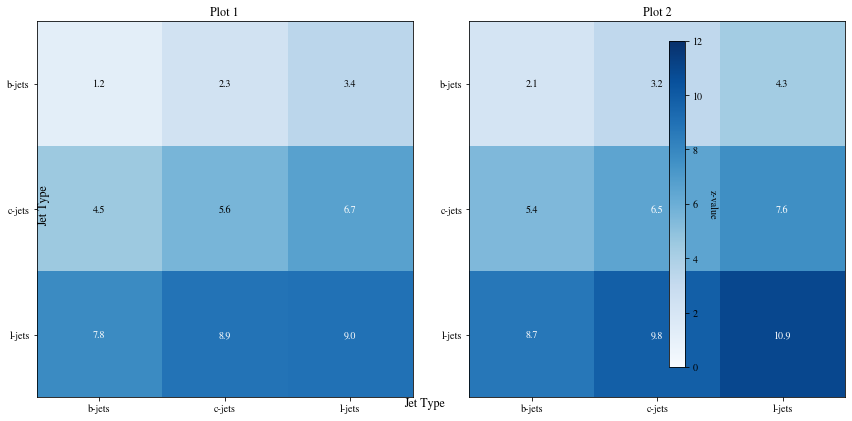

In [29]:
# Create two 3x3 matrices of z-values
data1 = np.array([[1.2, 2.3, 3.4],
                  [4.5, 5.6, 6.7],
                  [7.8, 8.9, 9.0]])

data2 = np.array([[2.1, 3.2, 4.3],
                  [5.4, 6.5, 7.6],
                  [8.7, 9.8, 10.9]])

# Define the axis labels
labels = ['b-jets', 'c-jets', 'l-jets']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first dataset
im1 = axes[0].imshow(data1, cmap='Blues', vmin=0, vmax=12)
axes[0].set_title("Plot 1")
axes[0].set_xticks(np.arange(len(labels)))
axes[0].set_xticklabels(labels)
axes[0].set_yticks(np.arange(len(labels)))
axes[0].set_yticklabels(labels)

# Annotate each cell for the first plot
for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        text = f"{data1[i, j]:.1f}"
        text_color = 'white' if im1.norm(data1[i, j]) > 0.5 else 'black'
        axes[0].text(j, i, text, ha='center', va='center', color=text_color)

# Plot the second dataset
im2 = axes[1].imshow(data2, cmap='Blues', vmin=0, vmax=12)
axes[1].set_title("Plot 2")
axes[1].set_xticks(np.arange(len(labels)))
axes[1].set_xticklabels(labels)
axes[1].set_yticks(np.arange(len(labels)))
axes[1].set_yticklabels(labels)

# Annotate each cell for the second plot
for i in range(data2.shape[0]):
    for j in range(data2.shape[1]):
        text = f"{data2[i, j]:.1f}"
        text_color = 'white' if im2.norm(data2[i, j]) > 0.5 else 'black'
        axes[1].text(j, i, text, ha='center', va='center', color=text_color)

# Create one colorbar for both plots. The 'ax' parameter takes the list of axes.
cbar = fig.colorbar(im2, ax=axes, location='right')
cbar.set_label('z-value', rotation=270, labelpad=15)

# Optional: Set common labels for x and y axes for clarity
fig.text(0.5, 0.04, 'Jet Type', ha='center', va='center', fontsize=12)
fig.text(0.06, 0.5, 'Jet Type', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
 _templs[hname][sam]

Histogram(
  Regular(100, 0.9, 1),
  Regular(100, 0, 1),
  storage=Weight()) # Sum: WeightedSum(value=2600.92, variance=15236.9) (WeightedSum(value=3.59179e+06, variance=2.10109e+07) with flow)

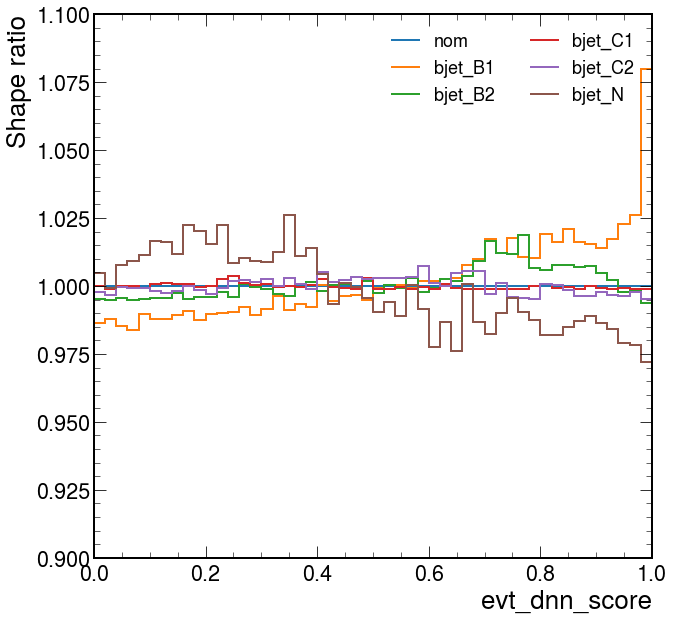

In [24]:
## (optional) checks

import copy
_templs = copy.deepcopy(templs_summary)

# rebin
for hname in _templs.keys():
    for sam in _templs[hname]:
        _templs[hname][sam] = _templs[hname][sam][0::bh.sum, ::bh.rebin(2)]

flv = 'bjet'

keys = ["nom"] + [k for k in _templs if (k.startswith(flv) and k.endswith("up"))]

# plotting: stacked histogram
fig, ax = plt.subplots()
varname = "evt_dnn_score"
varexpr, varaxis = config.variables[varname]
hist = bh.Histogram(varaxis, storage=bh.storage.Weight())[::bh.rebin(2)]
hep.histplot(
    [_templs[k]['sig'].values() / sum(_templs[k]['sig'].values()) / (_templs['nom']['sig'].values() / sum(_templs['nom']['sig'].values())) for k in keys],
    bins=hist.axes[0].edges,
    label=[k.replace('_up','') for k in keys],
    linewidth=2,
)

ax.set_xlim(varaxis.edges[0], varaxis.edges[-1])
ax.set_ylim(0.9, 1.1)
ax.set_xlabel(varname)
ax.set_ylabel("Shape ratio")
# ax.set_yscale("log")
ax.legend(prop={'size': 18}, loc='upper right', ncol=2)
plt.show()

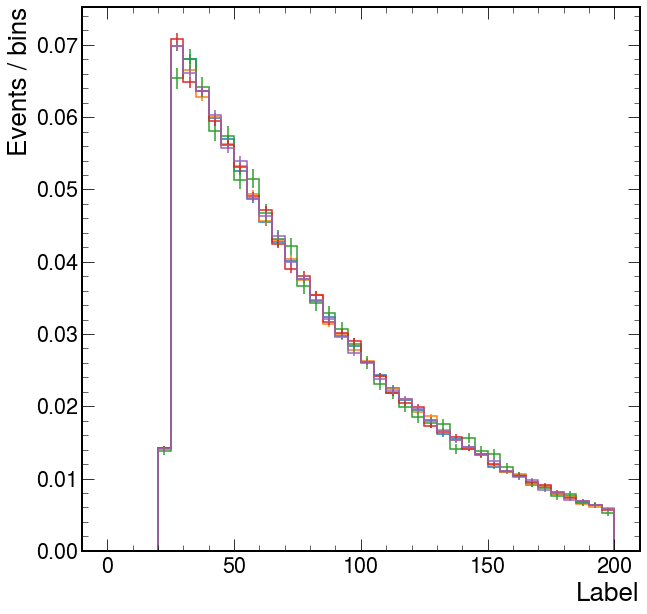

In [37]:
f, ax = plt.subplots(figsize=(10,10))

nbin, xmin, xmax = 40, 0, 200

for i in ["1", "2", "3", "4", "5"]:
    hist = bh.Histogram(bh.axis.Regular(nbin, xmin, xmax), storage=bh.storage.Weight())

    array = df0[i][(ak.num(df0[i].fj_pt) > 0) & (df0[i].lep_pid == -13)].lep_pt
    hist.fill(array)
    content, yerr = hist.view().value, np.sqrt(hist.view().variance)
    content, yerr = content / np.sum(content), yerr / np.sum(content)
    hep.histplot(content, bins=hist.axes[0].edges, yerr=yerr, label=f"Part {i}")

ax.set_xlabel('Label', ha='right', x=1.0); ax.set_ylabel('Events / bins', ha='right', y=1.0);

In [18]:
df = df0[i][ak.num(df0[i].fj_pt) > 0]

In [23]:
a = ak.any(np.abs(df.genpart_pid[:, [3,4,8,9]]) == 5, axis=1)

In [25]:
sum(df.is_wcb)

0

In [1]:
for i in range(2000):
    print(f'sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_{i}.root')

sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_0.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_1.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_2.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_3.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_4.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_5.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_6.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_7.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_8.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_9.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_10.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_11.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_12.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_13.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_14.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_15.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_16.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_17.root
sm_1l_fjak15/WJetsToLNu_HT50/events_delphes_18.root
sm_1l_fjak15/WJetsToLN

In [3]:
label_list = ["label_X_bb", "label_X_cc", "label_X_ss", "label_X_qq", "label_X_bc", "label_X_cs", "label_X_bq", "label_X_cq", "label_X_sq", "label_X_gg", "label_X_ee", "label_X_mm", "label_X_tauhtaue", "label_X_tauhtaum", "label_X_tauhtauh", "label_X_YY_bbbb", "label_X_YY_bbcc", "label_X_YY_bbss", "label_X_YY_bbqq", "label_X_YY_bbgg", "label_X_YY_bbee", "label_X_YY_bbmm", "label_X_YY_bbtauhtaue", "label_X_YY_bbtauhtaum", "label_X_YY_bbtauhtauh", "label_X_YY_bbb", "label_X_YY_bbc", "label_X_YY_bbs", "label_X_YY_bbq", "label_X_YY_bbg", "label_X_YY_bbe", "label_X_YY_bbm", "label_X_YY_cccc", "label_X_YY_ccss", "label_X_YY_ccqq", "label_X_YY_ccgg", "label_X_YY_ccee", "label_X_YY_ccmm", "label_X_YY_cctauhtaue", "label_X_YY_cctauhtaum", "label_X_YY_cctauhtauh", "label_X_YY_ccb", "label_X_YY_ccc", "label_X_YY_ccs", "label_X_YY_ccq", "label_X_YY_ccg", "label_X_YY_cce", "label_X_YY_ccm", "label_X_YY_ssss", "label_X_YY_ssqq", "label_X_YY_ssgg", "label_X_YY_ssee", "label_X_YY_ssmm", "label_X_YY_sstauhtaue", "label_X_YY_sstauhtaum", "label_X_YY_sstauhtauh", "label_X_YY_ssb", "label_X_YY_ssc", "label_X_YY_sss", "label_X_YY_ssq", "label_X_YY_ssg", "label_X_YY_sse", "label_X_YY_ssm", "label_X_YY_qqqq", "label_X_YY_qqgg", "label_X_YY_qqee", "label_X_YY_qqmm", "label_X_YY_qqtauhtaue", "label_X_YY_qqtauhtaum", "label_X_YY_qqtauhtauh", "label_X_YY_qqb", "label_X_YY_qqc", "label_X_YY_qqs", "label_X_YY_qqq", "label_X_YY_qqg", "label_X_YY_qqe", "label_X_YY_qqm", "label_X_YY_gggg", "label_X_YY_ggee", "label_X_YY_ggmm", "label_X_YY_ggtauhtaue", "label_X_YY_ggtauhtaum", "label_X_YY_ggtauhtauh", "label_X_YY_ggb", "label_X_YY_ggc", "label_X_YY_ggs", "label_X_YY_ggq", "label_X_YY_ggg", "label_X_YY_gge", "label_X_YY_ggm", "label_X_YY_bee", "label_X_YY_cee", "label_X_YY_see", "label_X_YY_qee", "label_X_YY_gee", "label_X_YY_bmm", "label_X_YY_cmm", "label_X_YY_smm", "label_X_YY_qmm", "label_X_YY_gmm", "label_X_YY_btauhtaue", "label_X_YY_ctauhtaue", "label_X_YY_stauhtaue", "label_X_YY_qtauhtaue", "label_X_YY_gtauhtaue", "label_X_YY_btauhtaum", "label_X_YY_ctauhtaum", "label_X_YY_stauhtaum", "label_X_YY_qtauhtaum", "label_X_YY_gtauhtaum", "label_X_YY_btauhtauh", "label_X_YY_ctauhtauh", "label_X_YY_stauhtauh", "label_X_YY_qtauhtauh", "label_X_YY_gtauhtauh", "label_X_YY_qqqb", "label_X_YY_qqqc", "label_X_YY_qqqs", "label_X_YY_bbcq", "label_X_YY_ccbs", "label_X_YY_ccbq", "label_X_YY_ccsq", "label_X_YY_sscq", "label_X_YY_qqbc", "label_X_YY_qqbs", "label_X_YY_qqcs", "label_X_YY_bcsq", "label_X_YY_bcs", "label_X_YY_bcq", "label_X_YY_bsq", "label_X_YY_csq", "label_X_YY_bcev", "label_X_YY_csev", "label_X_YY_bqev", "label_X_YY_cqev", "label_X_YY_sqev", "label_X_YY_qqev", "label_X_YY_bcmv", "label_X_YY_csmv", "label_X_YY_bqmv", "label_X_YY_cqmv", "label_X_YY_sqmv", "label_X_YY_qqmv", "label_X_YY_bctauev", "label_X_YY_cstauev", "label_X_YY_bqtauev", "label_X_YY_cqtauev", "label_X_YY_sqtauev", "label_X_YY_qqtauev", "label_X_YY_bctaumv", "label_X_YY_cstaumv", "label_X_YY_bqtaumv", "label_X_YY_cqtaumv", "label_X_YY_sqtaumv", "label_X_YY_qqtaumv", "label_X_YY_bctauhv", "label_X_YY_cstauhv", "label_X_YY_bqtauhv", "label_X_YY_cqtauhv", "label_X_YY_sqtauhv", "label_X_YY_qqtauhv", "label_QCD_bbccss", "label_QCD_bbccs", "label_QCD_bbcc", "label_QCD_bbcss", "label_QCD_bbcs", "label_QCD_bbc", "label_QCD_bbss", "label_QCD_bbs", "label_QCD_bb", "label_QCD_bccss", "label_QCD_bccs", "label_QCD_bcc", "label_QCD_bcss", "label_QCD_bcs", "label_QCD_bc", "label_QCD_bss", "label_QCD_bs", "label_QCD_b", "label_QCD_ccss", "label_QCD_ccs", "label_QCD_cc", "label_QCD_css", "label_QCD_cs", "label_QCD_c", "label_QCD_ss", "label_QCD_s", "label_QCD_light"]
for i in range(len(label_list)):
    print(i, f'"{label_list[i]}",')

0 "label_X_bb",
1 "label_X_cc",
2 "label_X_ss",
3 "label_X_qq",
4 "label_X_bc",
5 "label_X_cs",
6 "label_X_bq",
7 "label_X_cq",
8 "label_X_sq",
9 "label_X_gg",
10 "label_X_ee",
11 "label_X_mm",
12 "label_X_tauhtaue",
13 "label_X_tauhtaum",
14 "label_X_tauhtauh",
15 "label_X_YY_bbbb",
16 "label_X_YY_bbcc",
17 "label_X_YY_bbss",
18 "label_X_YY_bbqq",
19 "label_X_YY_bbgg",
20 "label_X_YY_bbee",
21 "label_X_YY_bbmm",
22 "label_X_YY_bbtauhtaue",
23 "label_X_YY_bbtauhtaum",
24 "label_X_YY_bbtauhtauh",
25 "label_X_YY_bbb",
26 "label_X_YY_bbc",
27 "label_X_YY_bbs",
28 "label_X_YY_bbq",
29 "label_X_YY_bbg",
30 "label_X_YY_bbe",
31 "label_X_YY_bbm",
32 "label_X_YY_cccc",
33 "label_X_YY_ccss",
34 "label_X_YY_ccqq",
35 "label_X_YY_ccgg",
36 "label_X_YY_ccee",
37 "label_X_YY_ccmm",
38 "label_X_YY_cctauhtaue",
39 "label_X_YY_cctauhtaum",
40 "label_X_YY_cctauhtauh",
41 "label_X_YY_ccb",
42 "label_X_YY_ccc",
43 "label_X_YY_ccs",
44 "label_X_YY_ccq",
45 "label_X_YY_ccg",
46 "label_X_YY_cce",
47 "label_